## Sentiment Analysis Model

#### Imports

In [5]:
%pip install keras

import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

Note: you may need to restart the kernel to use updated packages.


#### Text preprocessing and Embedding:

In [7]:
df_train = pd.read_csv('../Dataset/Train.csv')
df_test = pd.read_csv('../Dataset/Test.csv')
df_valid = pd.read_csv('../Dataset/Valid.csv')

In [8]:
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [9]:
# shapes of the dataframes
print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

(40000, 2)
(5000, 2)
(5000, 2)


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


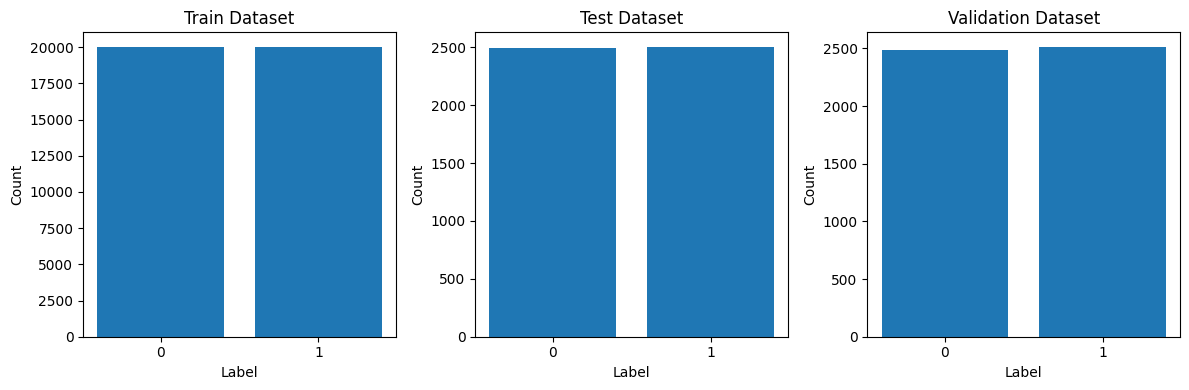

In [11]:
# Count the occurrences of each label in train, test, and val datasets
train_label_counts = df_train['label'].value_counts()
test_label_counts = df_test['label'].value_counts()
val_label_counts = df_valid['label'].value_counts()

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plot train dataset
axes[0].bar(train_label_counts.index, train_label_counts.values)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Train Dataset')
axes[0].set_xticks(train_label_counts.index)

# Plot test dataset
axes[1].bar(test_label_counts.index, test_label_counts.values)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Dataset')
axes[1].set_xticks(test_label_counts.index)

# Plot validation dataset
axes[2].bar(val_label_counts.index, val_label_counts.values)
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Count')
axes[2].set_title('Validation Dataset')
axes[2].set_xticks(val_label_counts.index)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [12]:
df_train["text"][2]

'Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you\'ve got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and who failed grade school composition do? "I\'ll show those old meanies, I\'ll put out my own movie and prove that you don\'t have to know nuttin about your topic to still make money!" Yeah, we already know that. The one thing watching this film did for me was to give me a little insight into underclass thinking. The next time I see a slut in a bar who looks like Diane Lane, I\'m running the other way. It\'s child abuse to let parents that worthless raise kids. It\'s audience abuse to simply stick Woodstock and the moonlanding into a flick as if that ipso facto means the film portrays 1969.'

Some text cleaning like removing characters and stopwords.

In [13]:
# text preprocessing
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [14]:
# Apply the cleaning function to both test and training datasets
df_train['text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_text(x))
df_valid['text'] = df_valid['text'].apply(lambda x: clean_text(x))

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swapn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [17]:
# remove stopwords
from nltk.corpus import stopwords

stop = stopwords.words('english')

df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_valid['text'] = df_valid['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [18]:
df_train['text'][2]

'people know particular time past like feel need try define time others replace woodstock civil war apollo moonlanding titanic sinking youve got realistic flick formulaic soap opera populated entirely lowlife trash kids young allowed go woodstock failed grade school composition ill show old meanies ill put movie prove dont know nuttin topic still make money yeah already know one thing watching film give little insight underclass thinking next time see slut bar looks like diane lane im running way child abuse let parents worthless raise kids audience abuse simply stick woodstock moonlanding flick ipso facto means film portrays'

<b>Creating an Embedding layer:</b><br>
Embedding layer converts our textual data into numeric form. It is then used as the first layer for the deep learning models in Keras.

In [19]:
# split the data into x_train and y_train dataframes
x_train = df_train['text']
y_train = df_train['label']

# split the data into x_test and y_test dataframes
x_test = df_test['text']
y_test = df_test['label']

# split the data into x_valid and y_valid dataframes
x_valid = df_valid['text']
y_valid = df_valid['label']

In [20]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library to convert text to sequences

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

X_train = word_tokenizer.texts_to_sequences(x_train)
X_test = word_tokenizer.texts_to_sequences(x_test)

In [21]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

155599

In [22]:
# Padding all reviews to fixed length 100
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [24]:
# loading GloVe word embeddings

embeddings_dictionary = dict()
glove_file = open('../Dataset/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
embedding_matrix.shape

(155599, 100)

#### Simple Neural Network

In [27]:
# Neural Network architecture
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

c:\Users\swapn\anaconda3\envs\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
# Model compiling
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
snn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    15,559,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,559,900 (59.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,559,900 (59.36 MB)

In [29]:
# Model training
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.6620 - loss: 0.6086 - val_acc: 0.7465 - val_loss: 0.5170
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.7963 - loss: 0.4437 - val_acc: 0.7598 - val_loss: 0.5101
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8203 - loss: 0.4052 - val_acc: 0.7563 - val_loss: 0.5150
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8344 - loss: 0.3797 - val_acc: 0.7510 - val_loss: 0.5288
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8428 - loss: 0.3634 - val_acc: 0.7551 - val_loss: 0.5358
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8541 - loss: 0.3452 - val_acc: 0.7466 - val_loss: 0.5524
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8539 - loss: 0.3417 - val_acc: 0.7471 - val_loss: 0.5623
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8608 - loss: 0.3317 - val_acc: 0.7430 - val_loss: 0.5833
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - ac

In [30]:
# Predictions on the Test Set
score = snn_model.evaluate(X_test, y_test, verbose=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.7262 - loss: 0.9049


In [31]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.9117937684059143
Test Accuracy: 0.7250000238418579


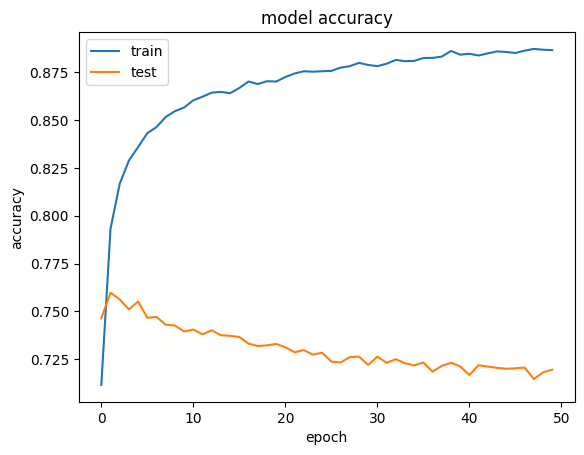

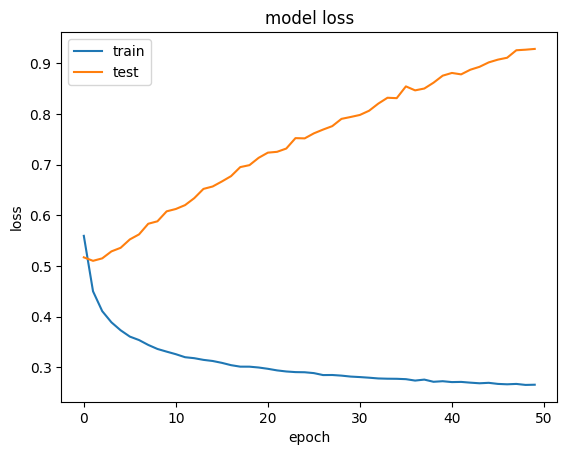

In [32]:
# Performance Visualization

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### Convolutional Neural Network

In [33]:
from keras.layers import Conv1D

In [34]:
# CNN architecture

cnn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [35]:
# Model compiling
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    15,559,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,559,900 (59.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,559,900 (59.36 MB)

In [36]:
# Model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - acc: 0.6980 - loss: 0.5630 - val_acc: 0.8266 - val_loss: 0.3889
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - acc: 0.8495 - loss: 0.3488 - val_acc: 0.8393 - val_loss: 0.3611
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - acc: 0.8862 - loss: 0.2845 - val_acc: 0.8491 - val_loss: 0.3455
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - acc: 0.9114 - loss: 0.2394 - val_acc: 0.8524 - val_loss: 0.3396
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - acc: 0.9350 - loss: 0.1979 - val_acc: 0.8424 - val_loss: 0.3588
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - acc: 0.9528 - loss: 0.1628 - val_acc: 0.8556 - val_loss: 0.3420
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - acc: 0.9706 - loss: 0.1287 - val_acc: 0.8454 - val_loss: 0.3689
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - acc: 0.9827 - loss: 0.1005 - val_acc: 0.8528 - val_loss: 0.3562
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/

In [37]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8398 - loss: 0.9375


In [38]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.8878273367881775
Test Accuracy: 0.842199981212616


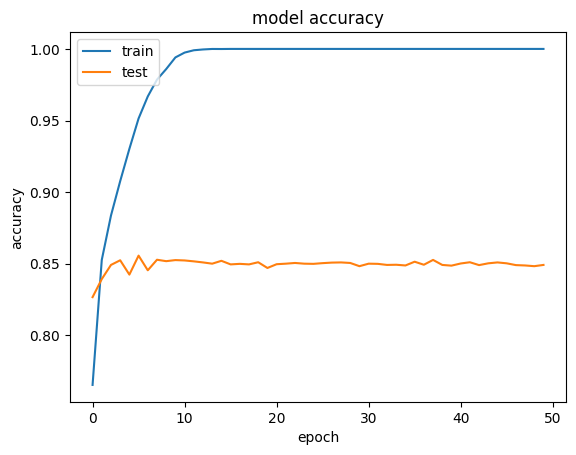

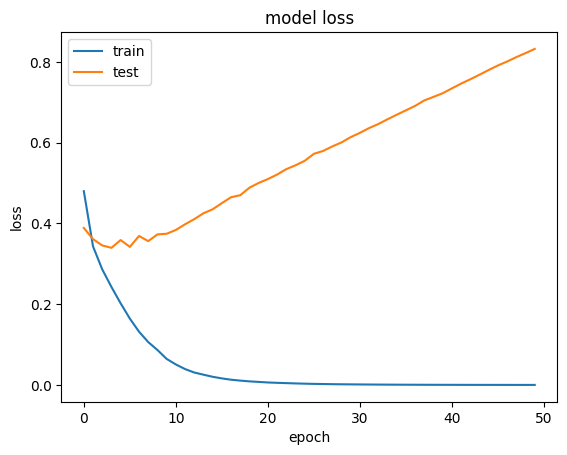

In [39]:
# Performance Visualization

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#### Long Short Term Memory (LSTM) Neural Network

In [40]:
from keras.layers import LSTM

In [41]:
# LSTM Architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

In [42]:
# Model compiling
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    15,559,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,559,900 (59.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,559,900 (59.36 MB)

In [43]:
# Model Training
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - acc: 0.6788 - loss: 0.5854 - val_acc: 0.8029 - val_loss: 0.4422
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - acc: 0.8004 - loss: 0.4452 - val_acc: 0.8144 - val_loss: 0.4104
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - acc: 0.8271 - loss: 0.3885 - val_acc: 0.8475 - val_loss: 0.3545
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - acc: 0.8505 - loss: 0.3500 - val_acc: 0.8503 - val_loss: 0.3445
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - acc: 0.8664 - loss: 0.3275 - val_acc: 0.8651 - val_loss: 0.3236
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 186ms/step - acc: 0.8714 - loss: 0.3063 - val_acc: 0.8589 - val_loss: 0.3309
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 185ms/step - acc: 0.8813 - loss: 0.2842 - val_acc: 0.8671 - val_loss: 0.3390
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - acc: 0.8971 - loss: 0.2617 - val_acc: 0.8313 - val_loss: 0.3703
Epoch 9/20
250/250 ━━━━━━━━━━━━━

In [44]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - acc: 0.8562 - loss: 0.4988


In [45]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5107185244560242
Test Accuracy: 0.8515999913215637


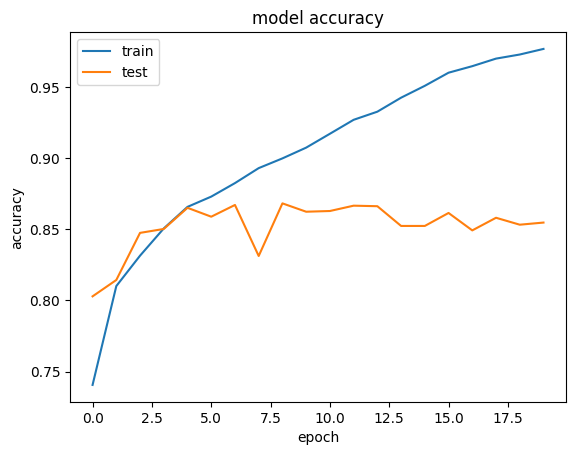

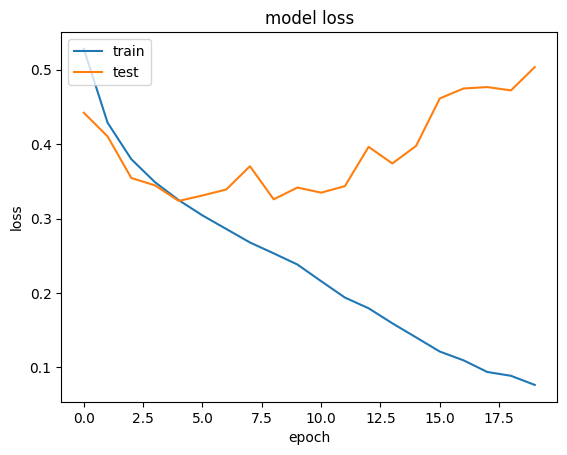

In [46]:
# Performance Visualization

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### Comparison

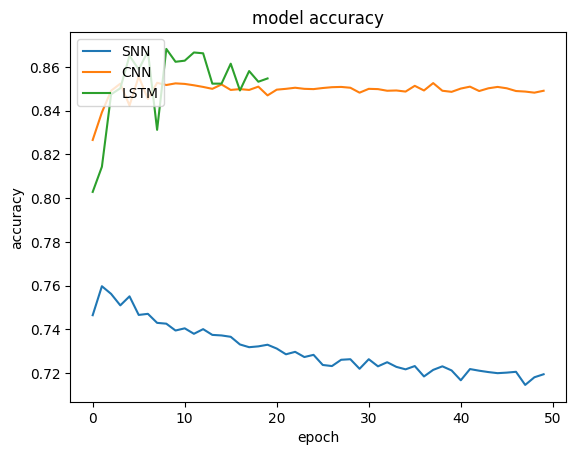

In [47]:
# comparing the performance of all the three models

plt.plot(snn_model_history.history['val_acc'])
plt.plot(cnn_model_history.history['val_acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['SNN','CNN','LSTM'], loc='upper left')
plt.show()

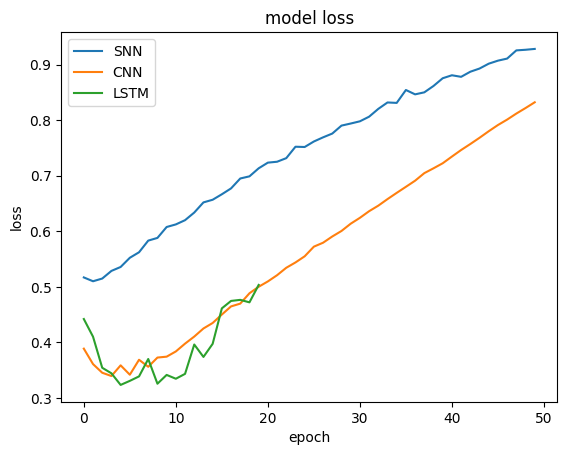

In [48]:
# comparing the performance of all the three models

plt.plot(snn_model_history.history['val_loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['SNN','CNN','LSTM'], loc='upper left')
plt.show()

#### Prediction time

In [49]:
df_valid.head()

,text,label
0,years since sharon stone awarded viewers legcr...,0
1,someone needed make car payment truly awful ma...,0
2,guidelines state comment must contain minimum ...,0
3,movie muddled mishmash clichés recent cinema p...,0
4,stan laurel became smaller half alltime greate...,0


In [50]:
# Predictions on the validation set

X_valid = df_valid['text']
y_valid = df_valid['label']

X_valid = word_tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)

# Predictions on the validation set

y_pred_snn = snn_model.predict(X_valid)
y_pred_cnn = cnn_model.predict(X_valid)
y_pred_lstm = lstm_model.predict(X_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


In [51]:
# Converting the predictions into binary values
for i in range(len(y_pred_snn)):
    if y_pred_snn[i]>=0.5:
        y_pred_snn[i]=1
    else:
        y_pred_snn[i]=0

for i in range(len(y_pred_cnn)):
    if y_pred_cnn[i]>=0.5:
        y_pred_cnn[i]=1
    else:
        y_pred_cnn[i]=0

for i in range(len(y_pred_lstm)):
    if y_pred_lstm[i]>=0.5:
        y_pred_lstm[i]=1
    else:
        y_pred_lstm[i]=0

In [52]:
# Performance on the validation set
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("SNN Accuracy:", accuracy_score(y_valid, y_pred_snn))
print("CNN Accuracy:", accuracy_score(y_valid, y_pred_cnn))
print("LSTM Accuracy:", accuracy_score(y_valid, y_pred_lstm))

SNN Accuracy: 0.7206
CNN Accuracy: 0.8502
LSTM Accuracy: 0.8544


In [53]:
# val loss and val accuracy of all the three models

print("SNN Loss:", snn_model_history.history['val_loss'][-1])
print("CNN Loss:", cnn_model_history.history['val_loss'][-1])
print("LSTM Loss:", lstm_model_history.history['val_loss'][-1])

print("SNN Accuracy:", snn_model_history.history['val_acc'][-1])
print("CNN Accuracy:", cnn_model_history.history['val_acc'][-1])
print("LSTM Accuracy:", lstm_model_history.history['val_acc'][-1])

SNN Loss: 0.9281874299049377
CNN Loss: 0.832190752029419
LSTM Loss: 0.5035293102264404
SNN Accuracy: 0.7195000052452087
CNN Accuracy: 0.8491250276565552
LSTM Accuracy: 0.8547499775886536


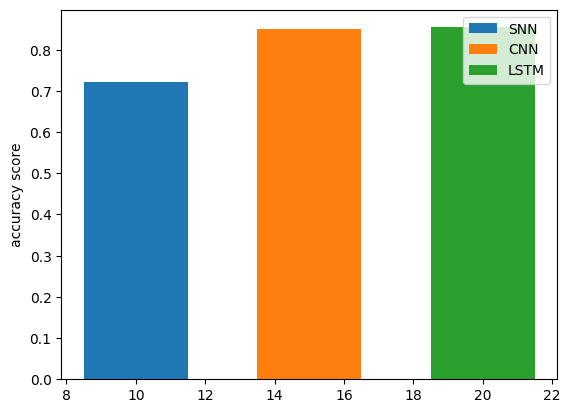

In [54]:
# plot accuracy scores of all the three models

plt.bar(10,accuracy_score(y_valid, y_pred_snn),3, label="SNN")
plt.bar(15,accuracy_score(y_valid, y_pred_cnn),3, label="CNN")
plt.bar(20,accuracy_score(y_valid, y_pred_lstm),3, label="LSTM")
plt.legend()
plt.ylabel('accuracy score')
plt.show()

In [55]:
# plot the confusion matrix
cm_snn = confusion_matrix(y_valid, y_pred_snn)
cm_cnn = confusion_matrix(y_valid, y_pred_cnn)
cm_lstm = confusion_matrix(y_valid, y_pred_lstm)

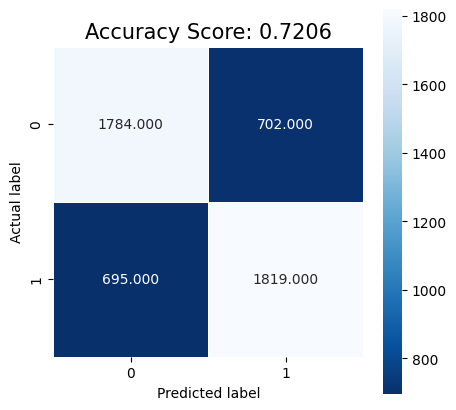

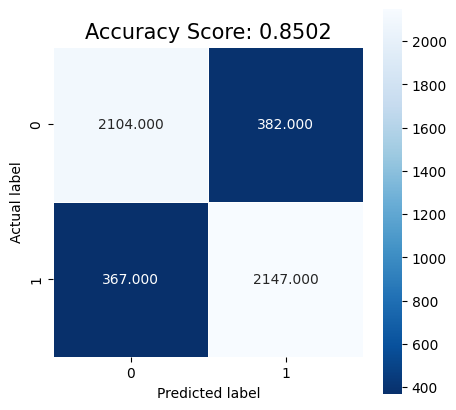

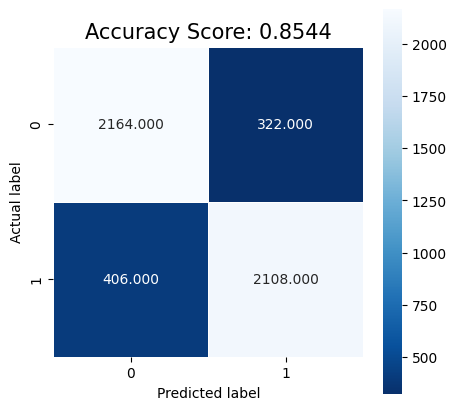

In [56]:
# plot the confusion matrix for SNN 

plt.figure(figsize=(5,5))
sns.heatmap(cm_snn, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_valid, y_pred_snn))
plt.title(all_sample_title, size = 15);

# plot the confusion matrix for CNN

plt.figure(figsize=(5,5))
sns.heatmap(cm_cnn, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_valid, y_pred_cnn))
plt.title(all_sample_title, size = 15);

# plot the confusion matrix for LSTM

plt.figure(figsize=(5,5))
sns.heatmap(cm_lstm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_valid, y_pred_lstm))
plt.title(all_sample_title, size = 15);
